In [4]:
import os
import sys
sys.path.append(os.pardir)
#from snowCode import makeSnowDF
from plot_snow_on_map import plotSnow
import pandas as pd
import pdb
%matplotlib inline

In [36]:
# makes files to be plotted
output_dir = os.path.join(os.getcwd(),os.pardir(),'output','grid_compare')
home_dir = os.getcwd()
data_dir = os.path.join(home_dir,os.pardir(), 'data')
input_zip_dir_24km = os.path.join(data_dir,'grid_compare','24km')
lat_long_area_filename_24km = 'lat_long_centroids_area_24km.csv'
lat_long_coords = {'lower_lat':25,'upper_lat':45,'lower_long':65,'upper_long':105} #set as lower and upper bounds for lat and long
makeDF_24km = makeSnowDF(data_dir,lat_long_area_filename_24km,lat_long_coords)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
#make 24km dataframe and save it
df_24km = makeDF_24km.createTimeSeriesDf(input_zip_dir_24km) 
df_24km.to_csv(output_dir+'/24km.csv')
#make 4km dataframe and save it
input_zip_dir_4km = data_dir+'grid_compare/4km/'
lat_long_area_filename_4km = 'lat_long_centroids_area_4km.csv'
makeDF_4km = makeSnowDF(data_dir,lat_long_area_filename_4km,lat_long_coords)
df_4 = makeDF_4km.createTimeSeriesDf(input_zip_dir_4km) 
df_4.to_csv(output_dir+'/4km.csv')

In [13]:
import os
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
import datetime
from matplotlib import rc
from matplotlib import rcParams
import pdb
%matplotlib inline
plt.show()

snow = '#FEFEFE'
cmap1 = LinearSegmentedColormap.from_list("my_colormap", (snow, snow), N=6, gamma=1)

def makeMap(proj='merc'):
    plt.cla()
    coords = {'lower_lat':25,'upper_lat':45,'lower_long':65,'upper_long':105} #set as lower and upper bounds for lat and long
    center = ((coords['upper_long']-coords['lower_long'])/2+coords['lower_long'],(coords['upper_lat']-coords['lower_lat'])/2+coords['lower_lat'])
    
    m = Basemap(projection=proj,
                llcrnrlat=coords['lower_lat'],
                urcrnrlat=coords['upper_lat'],
                llcrnrlon=coords['lower_long'],
                urcrnrlon=coords['upper_long'],
                lat_ts=20,
                resolution='c', 
                lat_0 = center[1],
                lon_0 = center[0])
    m.etopo()
    parallels = np.arange(0., 81, 10)
    meridians = np.arange(10, 351, 10)
    m.drawparallels(parallels, labels =[False, True, True, False])
    m.drawmeridians(meridians, labels =[True, False, False, True])
    return m

def snow_and_ice(x):
    if x==4 or x==3:
        x=1 
    else: 
        x=0
    return x


def make_plot_from_col(df, col, plot_dir):
    year, day = df[col].name.split("_")
    date = datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(day))
    title_string = date.strftime('%Y-%m-%d')
    m=makeMap('merc')
    data = df[col].apply(snow_and_ice)
    grid_z0 = griddata(points, data.values, (grid_x, grid_y), method='linear') #can be nearest, linear, or cubic interpolation
    grid_z0[ grid_z0 != 1 ] = np.nan
    m.contourf(grid_x, grid_y,grid_z0, latlon=False, cmap = cmap1, alpha=1)
    plt.title(title_string,fontsize=16, color = "black")
    plt.show()

def make_contour_grid(lat,lon, data):
    m=makeMap()
    x, y = m(lon,lat)
    points = np.transpose(np.array([x,y]))
    grid_x, grid_y = np.mgrid[min(x):max(x):3000j, min(y):max(y):3000j]
    points = np.transpose(np.array([x,y]))
    grid_z = griddata(points, data.values, (grid_x, grid_y), method='linear')
    grid_z[ grid_z != 1 ] = np.nan
    return (grid_x, grid_y, grid_z)

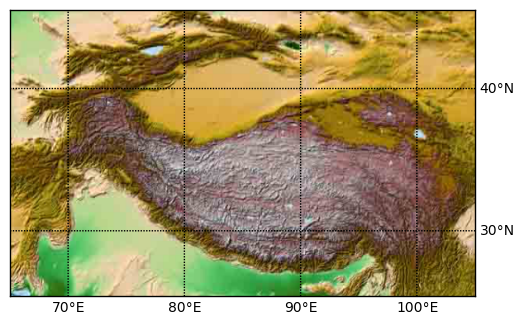

In [11]:
#make contour grids
output_dir = os.path.join(os.getcwd())
data_dir = os.path.join(os.getcwd(),os.pardir, 'data')
lat_long_area_filename_24km = 'tibet_lat_long_centroids_area_24km.csv'
lat_long_area_filename_4km = 'tibet_lat_long_centroids_area_4km.csv'
col_to_plot = '2015_001'
filename_24km = '24km.csv'
filename_4km = '4km.csv'
col_to_plot = '2015_001'

df_to_plot_24km = pd.read_csv(os.path.join(os.getcwd(), filename_24km))

data_24km = df_to_plot_24km[col_to_plot].apply(snow_and_ice)
df_lat_long_24km = pd.read_csv(os.path.join(data_dir,lat_long_area_filename_24km))
lat_24km = df_lat_long_24km['lat'].values
lon_24km = df_lat_long_24km['long'].values
(grid_x_L, grid_y_L, grid_zL) = make_contour_grid(lat_24km, lon_24km, data_24km)

df_to_plot_4km = pd.read_csv(os.path.join(os.getcwd(), filename_4km))

data_4km = df_to_plot_4km[col_to_plot].apply(snow_and_ice)
df_lat_long_4km = pd.read_csv(os.path.join(data_dir,lat_long_area_filename_4km))
lat_4km = df_lat_long_4km['lat'].values
lon_4km = df_lat_long_4km['long'].values
(grid_x_R, grid_y_R, grid_zR) = make_contour_grid(lat_4km, lon_4km, data_4km)

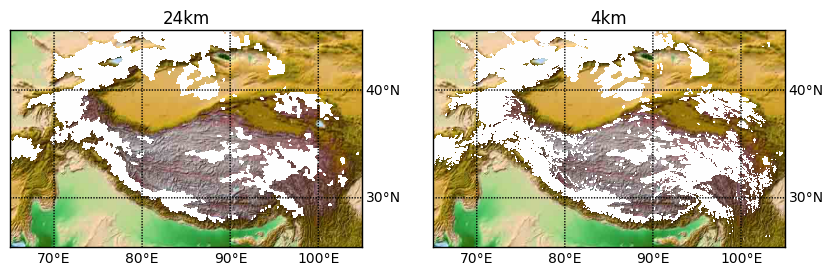

In [14]:
#%pylab inline

rcParams['figure.figsize'] = (10,10)
fig = plt.figure()
axL = fig.add_subplot(121)
plt.suptitle('Snow cover comparisons')
mapL=makeMap()
mapL.contourf(grid_x_L, grid_y_L,grid_zL, latlon=False, cmap = cmap1, alpha=1)
axL.set_title('24km')
axR = fig.add_subplot(122)
mapR=makeMap()
axR.set_title('4km')
mapR.contourf(grid_x_R, grid_y_R,grid_zR, latlon=False, cmap = cmap1, alpha=1)

In [107]:
lat_4km.shape

(721294,)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title('24km')
m = Basemap(projection='merc',
            llcrnrlat=coords['lower_lat'],
            urcrnrlat=coords['upper_lat'],
            llcrnrlon=coords['lower_long'],
            urcrnrlon=coords['upper_long'],
            lat_ts=20,
            resolution='c', 
            lat_0 = center[1],
            lon_0 = center[0])
m.etopo()
parallels = np.arange(0., 81, 10)
meridians = np.arange(10, 351, 10)
m.drawparallels(parallels, labels =[False, True, True, False])
m.drawmeridians(meridians, labels =[True, False, False, True])

In [8]:
lat_long_coords = {'lower_lat':25,'upper_lat':45,'lower_long':65,'upper_long':105}
filename_24km = '24km.csv'
col_to_plot = '2015_001'
df_to_plot_24km = pd.read_csv(os.path.join(os.getcwd(),filename_24km))
s_24km = plotSnow(lat_long_area_filename_24km,lat_long_coords)
m_24km = s_24km.make_plot_from_col(df_to_plot_24km, col_to_plot)

os.path.join(os.pardir,'output','grid_compare')

TypeError: 'str' object is not callable

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax.set_title("Hammer projection")
map = Basemap(projection='hammer', lon_0 = 10, lat_0 = 50)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

ax = fig.add_subplot(212)
ax.set_title("Robinson projection")
map = Basemap(projection='robin', lon_0 = 10, lat_0 = 50)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

plt.show()